# Intra-Cluster Light (ICL) profiles analysis in the Dark Energy Survey (DES)




In [1]:
import healpy as hp
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from healpy.rotator import Rotator
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample
import os
import os.path
import configparser
import sys
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [2]:
def rm_mrr(Lambda): #McClintock relation
    X_piv, z_piv = 40., 0.35
    A0, B0, C0, Z0 = 14.489,  1.356, -0.30, 0.275
    return (10.**A0) * ((Lambda/ X_piv)**B0)  * (((1+Z0) / (1+z_piv)) **(C0))
def criticaldens(z): # Critical density function  
    from astropy import units as u
    SolarM = u.Msun # solar masses
    kpc3 = u.kpc * u.kpc * u.kpc # Mpc^3
    Conv_factor = SolarM / kpc3
    rhoc_ = cosmo.critical_density(z)
    rhoc = rhoc_.to(Conv_factor)
    return rhoc

In [3]:
lambdamean = [24.061209, 35.77201, 50.39139, 81.282715]

rscale = []
for i in range(4):
    lambda_= lambdamean[i]
    m200m = rm_mrr(np.array(lambda_)) 
    rhoc = criticaldens(0.275)
    rhoc_prop = rhoc * (cosmo.h**2)
    rhom = cosmo.Om0 * rhoc * (1 + 0.275)**3
    r200m = np.cbrt( (3.*m200m) / (2000.*np.pi*rhom) ) 
    print('R200m = %.7s'%(r200m))
    rhom = cosmo.Om0 * rhoc_prop * (1 + 0.275)**3
    r200m = np.cbrt( (3.*m200m) / (2000.*np.pi*rhom) )
    print('R200m = %.7s'%(r200m))
    rscale.append(r200m.value)
    print(' ')

R200m = 876.144
R200m = 1111.33
 
R200m = 1048.14
R200m = 1329.50
 
R200m = 1223.72
R200m = 1552.21
 
R200m = 1518.93
R200m = 1926.67
 


In [4]:
ini_file= 'redmapper_y1.ini'
config = configparser.ConfigParser()
inifile = config.read(ini_file)
input_dir_rdmp=config.get('input', 'input_dir')
catalog=config.get('input', 'catalog_file')
flag_files_rdmp=[ii.strip() for ii in config.get('input', 'flag_files').split(',')]
save_dir_rdmp=config.get('output', 'save_dir')
grid_output_dir_rdmp=config.get('grid_output', 'save_dir')
rdmp=pyfits.open(catalog)[1].data
flags_rdmp=np.zeros(len(rdmp))+1
indices_rdmp=np.arange(len(rdmp))

/home/hillysson/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.
  This is separate from the ipykernel package so we can avoid doing imports until


### ICL jacknife profiles subtraction

In [5]:
str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']



numflag = 0
flag = ['', '_scaled', '_z19'][numflag]
flag

''

/home/hillysson/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


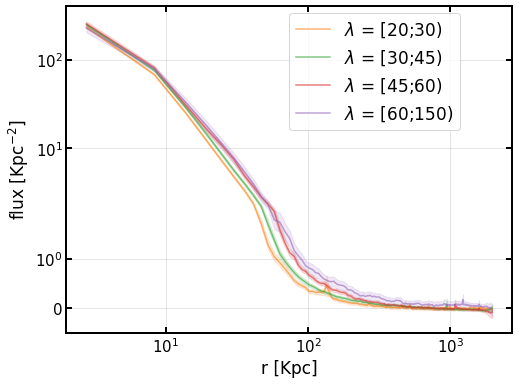

In [6]:
fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')
plt.yscale('symlog')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea_, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    mea = mea_
    up = mea+std
    low = mea-std
    
    
    # clusters: m200 and r200
    #lambda_= lambdamean[i]
    #m200 = rm_mrr(np.array(lambda_))  
    #rhoc = criticaldens(0.275)
    #r200 = np.cbrt( (3.*m200) / (2000.*np.pi*rhoc) ) 
    #print(r200)
    
    plt.plot(r_red, mea, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, up, low, color=colors[i], alpha=0.15, label='')

plt.ylabel('flux [Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=0, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.5, 0.98), loc=2, fontsize=17,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


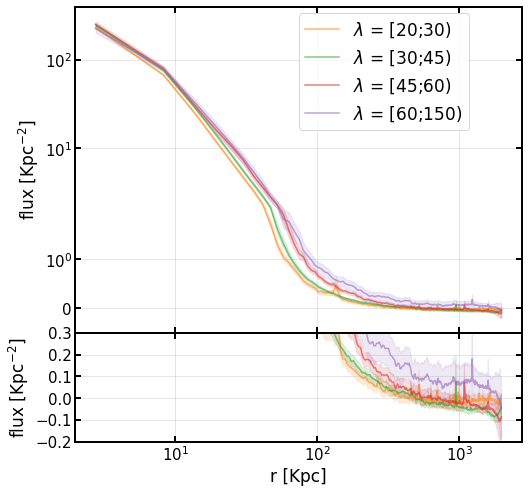

In [8]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8,8))  
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
plt.xscale('log')
plt.yscale('symlog')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']



for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea_, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    mea = mea_
    up = mea+std
    low = mea-std
    
    plt.plot(r_red, mea, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, up, low, color=colors[i], alpha=0.15, label='')

plt.ylabel('flux [Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=0, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax0.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.5, 0.98), loc=2, fontsize=17,borderaxespad=0.,numpoints=1,scatterpoints=1)

ax1 = plt.subplot(gs[1],sharex=ax0)
plt.xscale('log')


plt.grid(alpha=0.4)

colors = ['C1','C2','C3','C4']



for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]

    
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    
    r_red, mea_, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    mea = mea_
    up = mea+std
    low = mea-std
    

    #mag = 30 - 2.5 * np.log10(mea)
    #mag_up = 30 - 2.5 *np.log10(up)
    #mag_low = 30 - 2.5 * np.log10(low)
    
    
    plt.plot(r_red, mea, '-', lw=1.5,alpha=0.6,color=colors[i],label='')
    plt.fill_between(r_red, up, low, color=colors[i], alpha=0.15, label='')

plt.ylabel('flux [Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
plt.ylim(-0.2, 0.3)

plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=0, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.locator_params(axis='y', nbins=5)
[ax1.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


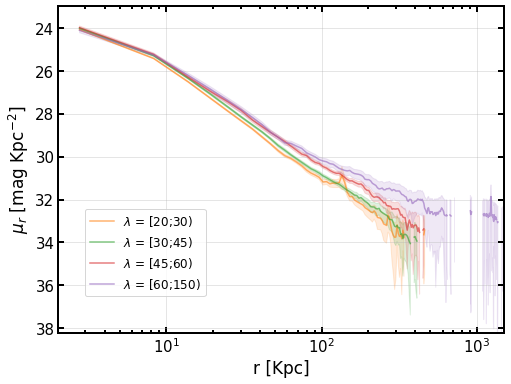

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in greater


52.57 Kpc
262.84 Kpc
 
62.89 Kpc
314.44 Kpc
 
73.42 Kpc
367.12 Kpc
 
91.14 Kpc
455.68 Kpc
 


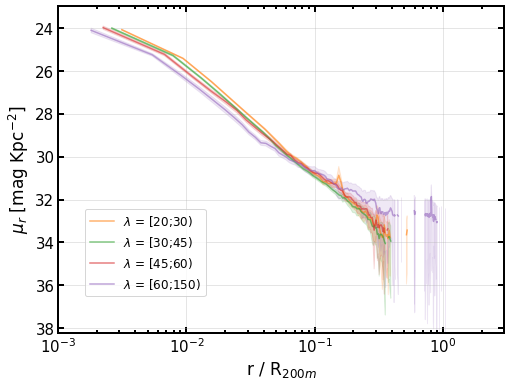

In [8]:

fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']



for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std, mag_unc = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2], jacknife_profile.T[3]
    f0 = 10**(30/-2.5)
    sigma = std
    flux = mea
    mu = (30 - 2.5 * np.log10(f0*2.5*np.log10(np.e)*sigma**2))  - 2.5 * np.log10(np.e) * np.arcsinh(flux/ (2*f0*1.042*sigma) )
    #mag_unc = np.sqrt( ( (2.5 * np.log10(np.e) )**2 * (f0 * sigma) **2 ) / ( 4*(1.042 * sigma) * (f0 * 1.042*sigma)**2  + flux**2)  )
    
    up = mea+std
    low = mea-std
    
    
    mag0 = -2.5 * np.log10(0.1)
    mag = 30 - 2.5 * np.log10(mea)
    #mag = mu
    mag_up = 30 - 2.5 *np.log10(up)
    #mag_up = mag + mag_unc
    mag_low = 30 - 2.5 * np.log10(low)
    #mag_low = mag - mag_unc
    
    mask = mag >-30000
    for kk in range(len(mask)):
        if mask[kk] == False:
            mag_up[kk] = np.nan
            mag_low[kk] = np.nan
            
    #mag_up = mag_up[mask]
    #mag_low = mag_low[mask]
    #r_red2 = r_red[mask]
    
    # clusters: m200 and r200
    #lambda_= lambdamean[i]
    #m200 = rm_mrr(np.array(lambda_))  
    #rhoc = criticaldens(0.275)
    #r200 = np.cbrt( (3.*m200) / (2000.*np.pi*rhoc) ) 
    
    n_mag = []
    for l in range(359):
        if str(mag_low[l])=='nan':
            n_mag.append(mag_low[l])
        else:
            n_mag.append(mag[l])
   
    
    #plt.plot(r_red[mask], mag[mask], '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    #plt.fill_between(r_red[mask], mag_up[mask], mag_low[mask], color=colors[i], alpha=0.15, label='')
    plt.plot(r_red, n_mag, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    #if i == 3:
        #print(mag[-100:]);print(mag_low[-100:]);print(mag_unc[-100:])
    plt.fill_between(r_red, mag_up, mag_low, color=colors[i], alpha=0.15, label='')
    
    if flag == '':
        hight= 37.0+0.3*i
        #plt.plot([2.754,rscale[i]], [hight,hight], '-', lw=1.5,alpha=0.6,color=colors[i])

plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(38.2,23)
plt.xlim(2,1500)
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################



fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']

for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    
    
    mag = 30 - 2.5 * np.log10(mea)
    mag_up = 30 - 2.5 *np.log10(up)
    mag_low = 30 - 2.5 * np.log10(low)
    
    mask = mag >-30000
    for kk in range(len(mask)):
        if mask[kk] == False:
            mag_up[kk] = np.nan
            mag_low[kk] = np.nan
            
    #mag_up = mag_up[mask]
    #mag_low = mag_low[mask]
    #r_red2 = r_red[mask]
    
    # clusters: m200 and r200
    lambdamean = [24.061209, 35.77201, 50.39139, 81.282715]
    lambda_= lambdamean[i]
    m200m = rm_mrr(np.array(lambda_))  
    rhoc = criticaldens(0.275)        
    rhoc_prop = rhoc  #* (cosmo.h**2)
    rhom = cosmo.Om0 * rhoc_prop * (1 + 0.275)**3
    r200m = np.cbrt( (3.*m200m) / (2000.*np.pi*rhom) )  
    
    
    print('%.2f Kpc'%(r200m*0.06).value)
    print('%.2f Kpc'%(r200m*0.3).value)
    print(' ')
    
    n_mag = []
    for l in range(359):
        if str(mag_low[l])=='nan':
            n_mag.append(mag_low[l])
        else:
            n_mag.append(mag[l])
   
    
    #plt.plot(r_red[mask], mag[mask], '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    #plt.fill_between(r_red[mask], mag_up[mask], mag_low[mask], color=colors[i], alpha=0.15, label='')
    plt.plot(r_red/r200m, n_mag, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    #if i == 3:
        #print(mag[-100:]);print(mag_low[-100:]);print(mag_unc[-100:])
    plt.fill_between(r_red/r200m, mag_up, mag_low, color=colors[i], alpha=0.15, label='')
    
    if flag == '':
        hight= 37.0+0.3*i
        #plt.plot([2.754,rscale[i]], [hight,hight], '-', lw=1.5,alpha=0.6,color=colors[i])

plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(38.2,23)
plt.xlim(0.001,3)
plt.xlabel('r / R$_{200m}$', fontsize=17)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


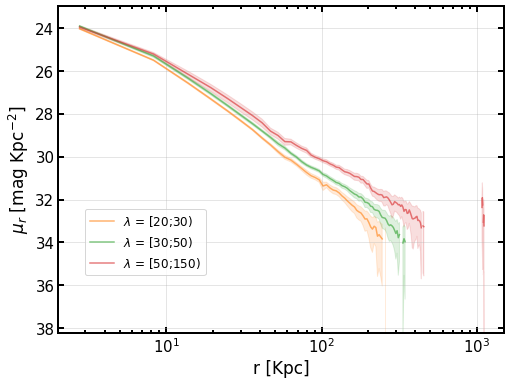

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in greater


52.36 Kpc
261.78 Kpc
 
64.41 Kpc
322.05 Kpc
 
84.70 Kpc
423.51 Kpc
 


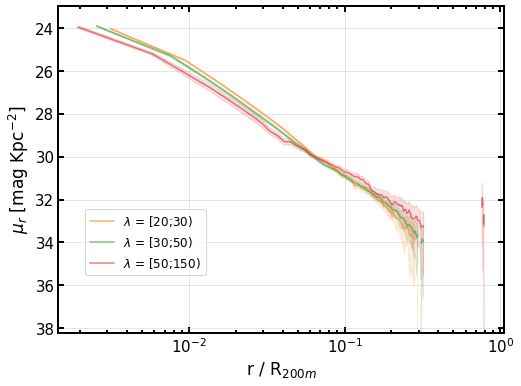

In [10]:

fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']


varflag = flag
flag = '_z19'

for i in range(3):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;50)',
                 '$\lambda$ = [50;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    

    mag = 30 - 2.5 * np.log10(mea)
    mag_up = 30 - 2.5 *np.log10(up)
    mag_low = 30 - 2.5 * np.log10(low)
    
    mask = mag >-30000
    for kk in range(len(mask)):
        if mask[kk] == False:
            mag_up[kk] = np.nan
            mag_low[kk] = np.nan
            
    #mag_up = mag_up[mask]
    #mag_low = mag_low[mask]
    #r_red2 = r_red[mask]
    
    # clusters: m200 and r200
    lambdamean = [23.846315, 37.714775, 69.12619]
    lambda_= lambdamean[i]
    m200m = rm_mrr(np.array(lambda_)) 
    rhoc = criticaldens(0.275)        
    rhoc_prop = rhoc # * (cosmo.h**2)
    rhom = cosmo.Om0 * rhoc_prop * (1 + 0.275)**3
    r200m = np.cbrt( (3.*m200m) / (2000.*np.pi*rhom) )  
    
    n_mag = []
    for l in range(359):
        if str(mag_low[l])=='nan':
            n_mag.append(mag_low[l])
        else:
            n_mag.append(mag[l])
   
    
    #plt.plot(r_red[mask], mag[mask], '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    #plt.fill_between(r_red[mask], mag_up[mask], mag_low[mask], color=colors[i], alpha=0.15, label='')
    plt.plot(r_red, n_mag, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    #if i == 3:
        #print(mag[-100:]);print(mag_low[-100:]);print(mag_unc[-100:])
    plt.fill_between(r_red, mag_up, mag_low, color=colors[i], alpha=0.15, label='')
    
    if flag == '':
        hight= 37.0+0.3*i
        #plt.plot([2.754,rscale[i]], [hight,hight], '-', lw=1.5,alpha=0.6,color=colors[i])

plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(38.2,23)
plt.xlim(2,1500)
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']

for i in range(3):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;50)',
                 '$\lambda$ = [50;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    
    

    mag = 30 - 2.5 * np.log10(mea)
    mag_up = 30 - 2.5 *np.log10(up)
    mag_low = 30 - 2.5 * np.log10(low)
    
    mask = mag >-30000
    for kk in range(len(mask)):
        if mask[kk] == False:
            mag_up[kk] = np.nan
            mag_low[kk] = np.nan
            
    #mag_up = mag_up[mask]
    #mag_low = mag_low[mask]
    #r_red2 = r_red[mask]
    
    # clusters: m200 and r200
    lambdamean = [23.846315, 37.714775, 69.12619]
    lambda_= lambdamean[i]
    m200m = rm_mrr(np.array(lambda_))  
    rhoc = criticaldens(0.275)        
    rhoc_prop = rhoc # * (cosmo.h**2)
    rhom = cosmo.Om0 * rhoc_prop * (1 + 0.275)**3
    r200m = np.cbrt( (3.*m200m) / (2000.*np.pi*rhom) )  
    
    
    print('%.2f Kpc'%(r200m*0.06).value)
    print('%.2f Kpc'%(r200m*0.3).value)
    print(' ')
   
    n_mag = []
    for l in range(359):
        if str(mag_low[l])=='nan':
            n_mag.append(mag_low[l])
        else:
            n_mag.append(mag[l])
    #plt.plot(r_red[mask], mag[mask], '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    #plt.fill_between(r_red[mask], mag_up[mask], mag_low[mask], color=colors[i], alpha=0.15, label='')
    plt.plot(r_red/r200m, n_mag, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    #if i == 3:
        #print(mag[-100:]);print(mag_low[-100:]);print(mag_unc[-100:])
    
    plt.fill_between(r_red/r200m, mag_up, mag_low, color=colors[i], alpha=0.15, label='')
    
    if flag == '':
        hight= 37.0+0.3*i
        #plt.plot([2.754,rscale[i]], [hight,hight], '-', lw=1.5,alpha=0.6,color=colors[i])

plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(38.2,23)
#plt.xlim(2,1500)
plt.xlabel('r / R$_{200m}$', fontsize=17)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

flag = varflag

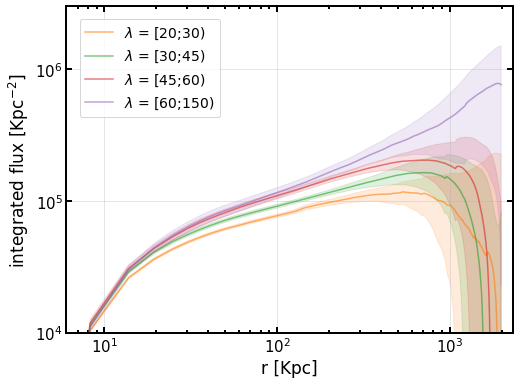

In [7]:

fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')
plt.yscale('symlog')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']

zz = list(np.arange(4))
zz_up = list(np.arange(4))
zz_low = list(np.arange(4))
for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    #dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'int_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    up = mea+std
    low = mea-std
    
    plt.plot(r_red, mea, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, up, low, color=colors[i], alpha=0.15, label='')
    
    #nn = [50,150,300, 500]
    #nn = [30,50,150, 500]
    nn = [15,50,150, 300, 500]
    
    zz[i] = [np.interp(nn[0], r_red, mea),
             np.interp(nn[1], r_red, mea),
             np.interp(nn[2], r_red, mea),
             np.interp(nn[3], r_red, mea), #]
             np.interp(nn[4], r_red, mea)]
    
    zz_up[i] = [np.interp(nn[0], r_red, up),
             np.interp(nn[1], r_red, up),
             np.interp(nn[2], r_red, up),
             np.interp(nn[3], r_red, up), #]
             np.interp(nn[4], r_red, up)]
    
    zz_low[i] = [np.interp(nn[0], r_red, low),
             np.interp(nn[1], r_red, low),
             np.interp(nn[2], r_red, low),
             np.interp(nn[3], r_red, low), #]
             np.interp(nn[4], r_red, low)]
    
    


plt.xticks(fontsize = 0)
plt.yscale('symlog')

plt.ylabel('integrated flux [Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
if flag == '':
    plt.xlim(6, 2.3e3)
    plt.ylim(1e4, 3e6)
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.03, 0.96), loc=2, fontsize=14,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

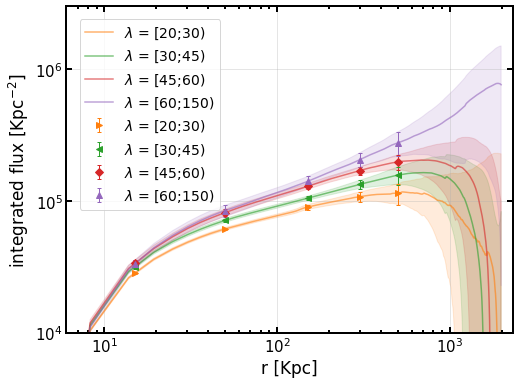

In [8]:

fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')
plt.yscale('symlog')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']
symbols = ['>', '<', 'D', '^', 'o',]

nn = [15,50,150, 300, 500]

zz = list(np.arange(4))
zz_up = list(np.arange(4))
zz_low = list(np.arange(4))


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    #dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'int_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    up = mea+std
    low = mea-std
    
    plt.plot(r_red, mea, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, up, low, color=colors[i], alpha=0.15, label='')
    
    zz[i] = [np.interp(nn[0], r_red, mea),
             np.interp(nn[1], r_red, mea),
             np.interp(nn[2], r_red, mea),
             np.interp(nn[3], r_red, mea), #]
             np.interp(nn[4], r_red, mea)]
    
    zz_up[i] = [np.interp(nn[0], r_red, up),
             np.interp(nn[1], r_red, up),
             np.interp(nn[2], r_red, up),
             np.interp(nn[3], r_red, up), #]
             np.interp(nn[4], r_red, up)]
    
    zz_low[i] = [np.interp(nn[0], r_red, low),
             np.interp(nn[1], r_red, low),
             np.interp(nn[2], r_red, low),
             np.interp(nn[3], r_red, low), #]
             np.interp(nn[4], r_red, low)]
    
    #print(zz[i])
    ulimit =np.array(zz_up[i])-np.array(zz[i])
    llimit =np.array(zz[i])-np.array(zz_low[i])
    
    #plt.plot(nn, zz[i], '.', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.errorbar(nn, zz[i], yerr=[ulimit,llimit], color=colors[i], fmt=symbols[i],label=str_ngals[i], markersize='6', ecolor=colors[i],capsize=2, elinewidth=1.)
    
    

    
    


plt.xticks(fontsize = 0)
plt.yscale('symlog')

plt.ylabel('integrated flux [Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
if flag == '':
    plt.xlim(6, 2.3e3)
    plt.ylim(1e4, 3e6)
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.03, 0.96), loc=2, fontsize=14,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


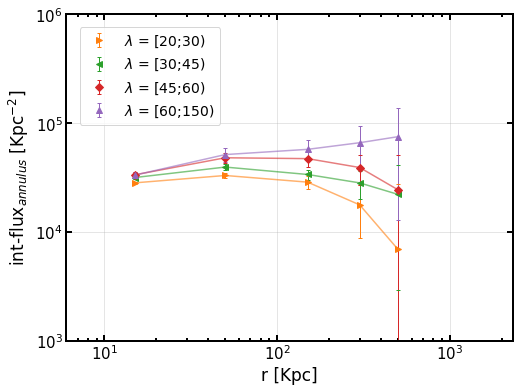

In [65]:

fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')
plt.yscale('symlog')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']
symbols = ['>', '<', 'D', '^', 'o',]

nn = [15,50,150, 300, 500]

zz = list(np.arange(4))
zz_up = list(np.arange(4))
zz_low = list(np.arange(4))




for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    #dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'int_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    up = mea+std
    low = mea-std
    
    #plt.plot(r_red, mea, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    #plt.fill_between(r_red, up, low, color=colors[i], alpha=0.15, label='')
    
    zz[i] = [np.interp(nn[0], r_red, mea),
             np.interp(nn[1], r_red, mea),
             np.interp(nn[2], r_red, mea),
             np.interp(nn[3], r_red, mea), #]
             np.interp(nn[4], r_red, mea)]
    
    zz_up[i] = [np.interp(nn[0], r_red, up),
             np.interp(nn[1], r_red, up),
             np.interp(nn[2], r_red, up),
             np.interp(nn[3], r_red, up), #]
             np.interp(nn[4], r_red, up)]
    
    zz_low[i] = [np.interp(nn[0], r_red, low),
             np.interp(nn[1], r_red, low),
             np.interp(nn[2], r_red, low),
             np.interp(nn[3], r_red, low), #]
             np.interp(nn[4], r_red, low)]
    
    #print(zz[i])
    #print(aa)

    
    #plt.plot(nn, zz[i], '.', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    
    
    
    means_ = []
    ulimit = []
    llimit = []
    aa = 0.
    for j in range(len(zz[i])):
        means_.append(np.array(zz[i][j])-np.array(aa))
        ulimit.append(np.array(zz_up[i][j])-np.array(zz[i][j]))
        llimit.append(np.array(zz[i][j])-np.array(zz_low[i][j]))

        aa = zz[i][j]
        #print(' ')
    
    plt.plot(nn, means_, '-', lw=1.5,alpha=0.6,color=colors[i],label='')
    plt.errorbar(nn, means_, yerr=[ulimit,llimit], color=colors[i], fmt=symbols[i],label=str_ngals[i], markersize='6', ecolor=colors[i],capsize=2, elinewidth=1.)
        
        
    #print(' ')
    


plt.xticks(fontsize = 0)
plt.yscale('symlog')

plt.ylabel('int-flux$_{annulus}$ [Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
if flag == '':
    plt.xlim(6, 2.3e3)
    plt.ylim(1e3, 1e6)
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.03, 0.96), loc=2, fontsize=14,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual bo

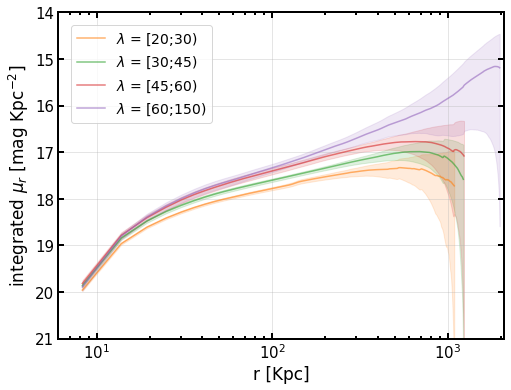

In [44]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    
    jacknife_profile=np.loadtxt(dir_ind+'int_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    up = mea+std
    low = mea-std
    
    mag = 30 - 2.5 * np.log10(mea)
    mag_up = 30 - 2.5 *np.log10(up)
    mag_low = 30 - 2.5 * np.log10(low)
    mask = (mag_low>-30000)
    
    
    plt.plot(r_red[mask ], mag[mask ], '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red[mask ], mag_up[mask ], mag_low[mask ], color=colors[i], alpha=0.15, label='')

plt.ylabel('integrated $\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
if flag == '':
    plt.xlabel('r [Kpc]', fontsize=17)
    plt.ylim(21,14)
    plt.xlim(6,2100)
if flag == '_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
    plt.ylim(37,31)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.03, 0.96), loc=2, fontsize=14,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


157.1417781962293 48426.07203938503
229.95734756878437 52447.469455978295
300.02002714648063 59847.537124193834
487.5102033447936 51365.419890215875
 
48.40409274930531 28998.5529365736
255.54369062877313 60588.5357500997
606.8078474850481 83018.70010750144
1194.392412940491 88481.36532051489
2029.6543383631233 74669.0371533885


/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


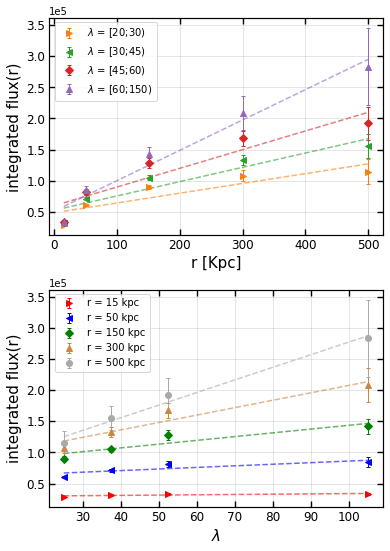

In [1]:
import healpy as hp
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from healpy.rotator import Rotator
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample
import os
import os.path
import configparser
import sys
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


##########################
## reading the ini file ##
##########################

ini_file= 'redmapper_y1.ini'
config = configparser.ConfigParser()
inifile = config.read(ini_file)
input_dir_rdmp=config.get('input', 'input_dir')
catalog=config.get('input', 'catalog_file')
flag_files_rdmp=[ii.strip() for ii in config.get('input', 'flag_files').split(',')]
save_dir_rdmp=config.get('output', 'save_dir')
grid_output_dir_rdmp=config.get('grid_output', 'save_dir')
rdmp=pyfits.open(catalog)[1].data
flags_rdmp=np.zeros(len(rdmp))+1
indices_rdmp=np.arange(len(rdmp))


##########################
## setting the strings  ##
##########################

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']

numflag = 0
flag = ['', '_scaled', '_z19'][numflag]
flag

colors = ['C1','C2','C3','C4']
symbols = ['>', '<', 'D', '^', 'o',]




######################################
## getting the values in the y-axis ##
######################################

nn = [15,50,150, 300, 500]

zz = list(np.arange(4))
zz_up = list(np.arange(4))
zz_low = list(np.arange(4))


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    #dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'int_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    up = mea+std
    low = mea-std
    
    zz[i] = [np.interp(nn[0], r_red, mea),
             np.interp(nn[1], r_red, mea),
             np.interp(nn[2], r_red, mea),
             np.interp(nn[3], r_red, mea), #]
             np.interp(nn[4], r_red, mea)]
    
    zz_up[i] = [np.interp(nn[0], r_red, up),
             np.interp(nn[1], r_red, up),
             np.interp(nn[2], r_red, up),
             np.interp(nn[3], r_red, up), #]
             np.interp(nn[4], r_red, up)]
    
    zz_low[i] = [np.interp(nn[0], r_red, low),
             np.interp(nn[1], r_red, low),
             np.interp(nn[2], r_red, low),
             np.interp(nn[3], r_red, low), #]
             np.interp(nn[4], r_red, low)]


    
    
    
    
    
    
#########################
## plotting the figure ##
#########################

fig = plt.figure(figsize=(6,9))   
ax1 = plt.subplot(2,1,1)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)
 
str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']
symbols = ['>', '<', 'D', '^', 'o',]


for i in range(4):
    
    #zz_ = np.insert(zz[i], 0, 0)
    #sub_zz = zz_[1:]-zz_[:-1]
    colors = ['C1','C2','C3','C4','C5']
    
    ulimit =np.array(zz_up[i])-np.array(zz[i])
    llimit =np.array(zz[i])-np.array(zz_low[i])
       
    #plt.plot(nn, sub_zz, 'o-', label=str_ngals[i], color=colors[i])
    #plt.plot(nn, zz[i], 'o-', label=str_ngals[i], color=colors[i])
    
    plt.errorbar(np.array(nn), zz[i], yerr=[ulimit,llimit], color=colors[i], fmt=symbols[i], lw=1.5, label=str_ngals[i], markersize='6', ecolor=colors[i],capsize=2, elinewidth=1)
    coef1 = np.polyfit(nn, zz[i], 1)
    print(coef1[0], coef1[1])
    plt.plot(nn, coef1[0]*np.array(nn)+coef1[1], '--', lw=1.5, color=colors[i], label='', alpha=0.6)
    
    
plt.xlabel('r [Kpc]', fontsize=15)
plt.ylabel('integrated flux(r)', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ylim(0.1, 100)
[ax1.spines[axis].set_linewidth(1.2) for axis in ['top','bottom','left','right']]
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)
    
    
ax2 = plt.subplot(2,1,2)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)

rr=[25,37.5,52.5,100]
rr=[(20+30)/2,(30+45)/2,(45+60)/2,(60+150)/2]
str_ngals = ['r = %i kpc'%(nn[0]),
             'r = %i kpc'%(nn[1]),
             'r = %i kpc'%(nn[2]),
             'r = %i kpc'%(nn[3]), #]
             'r = %i kpc'%(nn[4])]


print(' ')
for i in range(5):
    #colors = ['navy','mediumorchid', 'violet', 'hotpink', 'red']
    colors = ['red','blue', 'green', 'peru', 'darkgrey']
    ulimit = np.array(zz_up).T[i]-np.array(zz).T[i]
    llimit = np.array(zz_up).T[i]-np.array(zz).T[i]
    
    plt.errorbar(rr, np.array(zz).T[i], yerr=[ulimit,llimit], color=colors[i], fmt=symbols[i],label=str_ngals[i], markersize='6', ecolor=colors[i],capsize=2, elinewidth=1.)
    
    #plt.plot(rr, np.array(zz).T[i], 'o', label=str_ngals[i], color=colors[i])
    coef1 = np.polyfit(rr, np.array(zz).T[i], 1)
    print(coef1[0], coef1[1])
    plt.plot(rr, coef1[0]*np.array(rr)+coef1[1], '--',label='', lw=1.5,color=colors[i], alpha=0.6)

plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('integrated flux(r)', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ylim(0.1, 100)
[ax2.spines[axis].set_linewidth(1.2) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0.25)
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

157.1417781962293 48426.07203938503
229.95734756878437 52447.469455978295
300.02002714648063 59847.537124193834
487.5102033447936 51365.419890215875
 
48.40409274930531 28998.5529365736
255.54369062877313 60588.5357500997
606.8078474850481 83018.70010750144
1194.392412940491 88481.36532051489
2029.6543383631233 74669.0371533885


/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


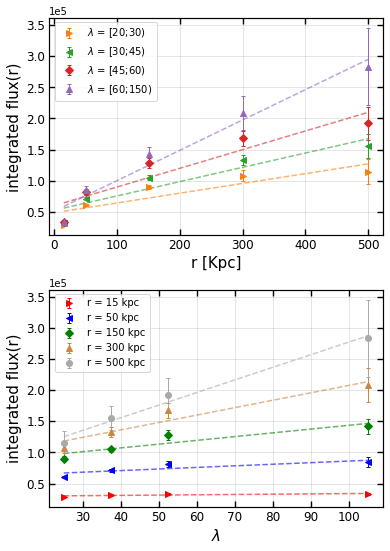

In [6]:

fig = plt.figure(figsize=(6,9))   
ax1 = plt.subplot(2,1,1)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)
 
str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']
symbols = ['>', '<', 'D', '^', 'o',]


for i in range(4):
    
    #zz_ = np.insert(zz[i], 0, 0)
    #sub_zz = zz_[1:]-zz_[:-1]
    colors = ['C1','C2','C3','C4','C5']
    
    ulimit =np.array(zz_up[i])-np.array(zz[i])
    llimit =np.array(zz[i])-np.array(zz_low[i])
       
    #plt.plot(nn, sub_zz, 'o-', label=str_ngals[i], color=colors[i])
    #plt.plot(nn, zz[i], 'o-', label=str_ngals[i], color=colors[i])
    
    plt.errorbar(np.array(nn), zz[i], yerr=[ulimit,llimit], color=colors[i], fmt=symbols[i], lw=1.5, label=str_ngals[i], markersize='6', ecolor=colors[i],capsize=2, elinewidth=1)
    coef1 = np.polyfit(nn, zz[i], 1)
    print(coef1[0], coef1[1])
    plt.plot(nn, coef1[0]*np.array(nn)+coef1[1], '--', lw=1.5, color=colors[i], label='', alpha=0.6)
    
    
plt.xlabel('r [Kpc]', fontsize=15)
plt.ylabel('integrated flux(r)', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ylim(0.1, 100)
[ax1.spines[axis].set_linewidth(1.2) for axis in ['top','bottom','left','right']]
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)
    
    
ax2 = plt.subplot(2,1,2)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)

rr=[25,37.5,52.5,100]
rr=[(20+30)/2,(30+45)/2,(45+60)/2,(60+150)/2]
str_ngals = ['r = %i kpc'%(nn[0]),
             'r = %i kpc'%(nn[1]),
             'r = %i kpc'%(nn[2]),
             'r = %i kpc'%(nn[3]), #]
             'r = %i kpc'%(nn[4])]


print(' ')
for i in range(5):
    #colors = ['navy','mediumorchid', 'violet', 'hotpink', 'red']
    colors = ['red','blue', 'green', 'peru', 'darkgrey']
    ulimit = np.array(zz_up).T[i]-np.array(zz).T[i]
    llimit = np.array(zz_up).T[i]-np.array(zz).T[i]
    
    plt.errorbar(rr, np.array(zz).T[i], yerr=[ulimit,llimit], color=colors[i], fmt=symbols[i],label=str_ngals[i], markersize='6', ecolor=colors[i],capsize=2, elinewidth=1.)
    
    #plt.plot(rr, np.array(zz).T[i], 'o', label=str_ngals[i], color=colors[i])
    coef1 = np.polyfit(rr, np.array(zz).T[i], 1)
    print(coef1[0], coef1[1])
    plt.plot(rr, coef1[0]*np.array(rr)+coef1[1], '--',label='', lw=1.5,color=colors[i], alpha=0.6)

plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('integrated flux(r)', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ylim(0.1, 100)
[ax2.spines[axis].set_linewidth(1.2) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0.25)
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

 
(47.471341807232214, 29056.31335289012)
('corr coef', 0.6912461804066917)
(250.30490606431312, 60883.27304024835)
('corr coef', 0.8352903953477391)
(586.2148242388635, 84125.78625287322)
('corr coef', 0.8954779824676632)
(1150.2998619060672, 91186.09630749255)
('corr coef', 0.9488516431361376)
(1915.4961054843338, 81562.04879459592)
('corr coef', 0.9803314339035801)


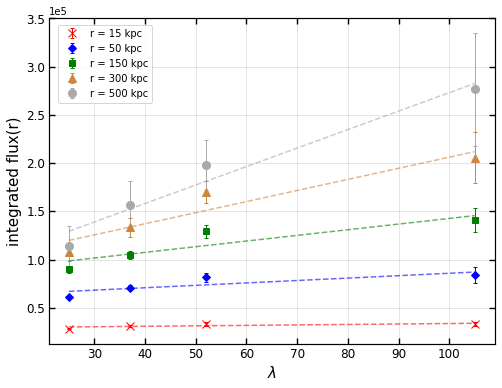

In [23]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""

    # Compute correlation matrix
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]


symbols = ['x', 'D', 's','^','o', ]
symbolsize = ['8','5','6','8','8']


fig = plt.figure(figsize=(8,6))   
ax = plt.subplot(1,1,1)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)

rr=[25,37.5,52.5,100]
rr=[(20+30)/2,(30+45)/2,(45+60)/2,(60+150)/2]
str_ngals = ['r = %i kpc'%(nn[0]),
             'r = %i kpc'%(nn[1]),
             'r = %i kpc'%(nn[2]),
             'r = %i kpc'%(nn[3]), #]
             'r = %i kpc'%(nn[4])]




print(' ')
for i in range(5):
    #colors = ['navy','mediumorchid', 'violet', 'hotpink', 'red']
    colors = ['red','blue', 'green', 'peru', 'darkgrey']
    ulimit = np.array(zz_up).T[i]-np.array(zz).T[i]
    llimit = np.array(zz_up).T[i]-np.array(zz).T[i]
    
  
    #plt.plot(rr, np.array(zz).T[i], 'o', label=str_ngals[i], color=colors[i])
    coef1 = np.polyfit(rr, np.array(zz).T[i], 1)
    print(coef1[0], coef1[1])
    
    cor = pearson_r(rr, np.array(zz).T[i])
    print('corr coef', cor)
    
    
    plt.errorbar(rr, np.array(zz).T[i], yerr=[ulimit,llimit], color=colors[i], fmt=symbols[i],label=str_ngals[i], markersize=symbolsize[i], ecolor=colors[i],capsize=2, elinewidth=1.)
  
    
    plt.plot(rr, coef1[0]*np.array(rr)+coef1[1], '--',label='', lw=1.5,color=colors[i], alpha=0.6)

plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('integrated flux(r)', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ylim(0.1, 100)
[ax.spines[axis].set_linewidth(1.2) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0.25)
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.savefig(save_dir_rdmp+'paper_figures/'+'rrdep.png', format='png', dpi=300)
plt.show()
##############################################################################

In [16]:

fig = plt.figure(figsize=(6,9))   
ax1 = plt.subplot(2,1,1)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)
 
str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']
symbols = ['>', '<', 'D', '^', 'o',]

aa = list(np.zeros(len(zz[0])))
for i in range(4):
    
    #zz_ = np.insert(zz[i], 0, 0)
    #sub_zz = zz_[1:]-zz_[:-1]
    colors = ['C1','C2','C3','C4','C5']
    
    ulimit =np.array(zz_up[i])-np.array(zz[i])
    llimit =np.array(zz[i])-np.array(zz_low[i])
       
    #plt.plot(nn, sub_zz, 'o-', label=str_ngals[i], color=colors[i])
    #plt.plot(nn, zz[i], 'o-', label=str_ngals[i], color=colors[i])
    print(aa)
    
    plt.errorbar(np.array(nn), zz[i]-aa[i], yerr=[ulimit,llimit], color=colors[i], fmt=symbols[i], lw=1.5, label=str_ngals[i], markersize='6', ecolor=colors[i],capsize=2, elinewidth=1)
    coef1 = np.polyfit(nn, zz[i]-aa[i], 1)
    #print(coef1[0], coef1[1])
    plt.plot(nn, coef1[0]*np.array(nn)+coef1[1], '--', lw=1.5, color=colors[i], label='', alpha=0.6)
    
    aa[i+1] = zz[i]
    #print(zz[i])
    print(aa)
    print(' ')
    

plt.xlabel('r [Kpc]', fontsize=15)
plt.ylabel('integrated flux(r)', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ylim(0.1, 100)
[ax1.spines[axis].set_linewidth(1.2) for axis in ['top','bottom','left','right']]
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)
    
    
ax2 = plt.subplot(2,1,2)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)

rr=[25,37.5,52.5,100]
rr=[(20+30)/2,(30+45)/2,(45+60)/2,(60+150)/2]
str_ngals = ['r = %i kpc'%(nn[0]),
             'r = %i kpc'%(nn[1]),
             'r = %i kpc'%(nn[2]),
             'r = %i kpc'%(nn[3]), #]
             'r = %i kpc'%(nn[4])]


print(' ')
for i in range(5):
    #colors = ['navy','mediumorchid', 'violet', 'hotpink', 'red']
    colors = ['red','blue', 'green', 'peru', 'darkgrey']
    ulimit = np.array(zz_up).T[i]-np.array(zz).T[i]
    llimit = np.array(zz_up).T[i]-np.array(zz).T[i]
    
    plt.errorbar(rr, np.array(zz).T[i], yerr=[ulimit,llimit], color=colors[i], fmt=symbols[i],label=str_ngals[i], markersize='6', ecolor=colors[i],capsize=2, elinewidth=1.)
    
    #plt.plot(rr, np.array(zz).T[i], 'o', label=str_ngals[i], color=colors[i])
    coef1 = np.polyfit(rr, np.array(zz).T[i], 1)
    print(coef1[0], coef1[1])
    plt.plot(rr, coef1[0]*np.array(rr)+coef1[1], '--',label='', lw=1.5,color=colors[i], alpha=0.6)

plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('integrated flux(r)', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=1.4, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ylim(0.1, 100)
[ax2.spines[axis].set_linewidth(1.2) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0.25)
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################

[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, [28244.10909271188, 61247.62932118082, 89849.89852885186, 107551.62518405542, 114602.52334534445], 0.0, 0.0, 0.0]
 
[0.0, [28244.10909271188, 61247.62932118082, 89849.89852885186, 107551.62518405542, 114602.52334534445], 0.0, 0.0, 0.0]


TypeError: unsupported operand type(s) for -: 'list' and 'list'

### t-student

In [116]:
#30 100 500


def tstudent(mea1, mea2):
    from scipy import stats

    ## Define 2 random distributions
    #Sample Size
    N = len(mea1)
    #Gaussian distributed data with mean = 2 and var = 1
    a = np.array(mea1)
    #Gaussian distributed data with with mean = 0 and var = 1
    b = np.array(mea2)


    ## Calculate the Standard Deviation
    #Calculate the variance to get the standard deviation

    #For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
    var_a = a.var(ddof=1)
    var_b = b.var(ddof=1)

    #std deviation
    s = np.sqrt((var_a + var_b)/2)

    ## Calculate the t-statistics
    t = (a.mean() - b.mean())/(s*np.sqrt(2/N))

    ## Compare with the critical t-value
    #Degrees of freedom
    df = 2*N - 2

    #p-value after comparison with the t 
    p = 1 - stats.t.cdf(t,df=df)
    
    
    return t, 2*p

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


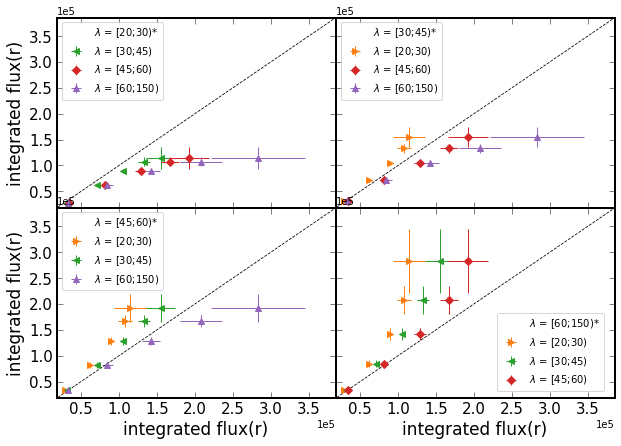

In [130]:
#30 100 500




str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']
colors = ['C1','C2','C3','C4', 'C5']
#nn = [30,50,150,500]

a = min([min(ii) for ii in zz_low])
b = max([max(ii) for ii in zz_up])

wi = 0.5
lws = 0.8
font = 17
fontl = 10

fig = plt.figure(figsize=(10,7))  
for j in range(4):
    ctrl = j
    
    for i in range(4):

        #################################################################################
        if j <= 1:
            ax2 = plt.subplot(2,2,j+1)
        if j > 1:
            ax2 = plt.subplot(2,2,j+1)


        
        hc_ulimit =np.array(zz_up[ctrl])-np.array(zz[ctrl])
        hc_llimit =np.array(zz[ctrl])-np.array(zz_low[ctrl])
        #print(i)
        #print(ctrl)

        if i != ctrl:        
            #t, p = tstudent(zz[ctrl], zz[i])
            
            ulimit =np.array(zz_up[i])-np.array(zz[i])
            llimit =np.array(zz[i])-np.array(zz_low[i])
            #plt.plot(zz[i], zz[ctrl],'-',alpha=0.2, lw=1.4, color=colors[i]) 
            plt.errorbar(zz[i], zz[ctrl], xerr=[ulimit,llimit], 
                         yerr=[hc_ulimit,hc_llimit], color=colors[i], 
                         fmt=symbols[i],label=str_ngals[i], 
                         markersize='6', ecolor=colors[i],capsize=0, elinewidth=1.)
        if i == ctrl:   
            plt.plot([1e4, 3e6], [1e4,3e6], 'k--', lw=lws, label='')
            plt.plot(np.array(zz[i])*0, np.array(zz[ctrl])*0, '.',
                         color=colors[i],label=str_ngals[i]+'*', markersize=0)

        plt.tick_params(direction='in',which='major', length=6, width=wi, labelsize=0.,
                       bottom='on', top='on', left='on', right ='on')
        plt.tick_params(direction='in',which='minor', length=3, width=wi, labelsize=0.,
                       bottom='on', top='on', left='on', right ='on')
        plt.subplots_adjust(wspace=0, hspace=0)
  
        [ax2.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
        plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, fontsize=fontl,borderaxespad=0.,numpoints=1,scatterpoints=1)
        
        if ctrl == 3: 
            plt.legend(bbox_to_anchor=(0.58, 0.45), loc=2, fontsize=fontl,borderaxespad=0.,numpoints=1,scatterpoints=1)

        
        if ctrl == 0 or ctrl == 2: 
            plt.ylabel('integrated flux(r)', fontsize=font)
            plt.yticks(fontsize=15)
        if ctrl == 2 or ctrl == 3: 
            plt.xlabel('integrated flux(r)', fontsize=font)
            plt.xticks(fontsize=15)
        if ctrl == 1 or ctrl == 3:
            plt.yticks(fontsize=0)
        plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        #plt.xlim(1e4, 3e6)
        #plt.ylim(1e4, 3e6)
        plt.ylim(a-10000, b+40000)
        plt.xlim(a-10000, b+40000)


plt.show()

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


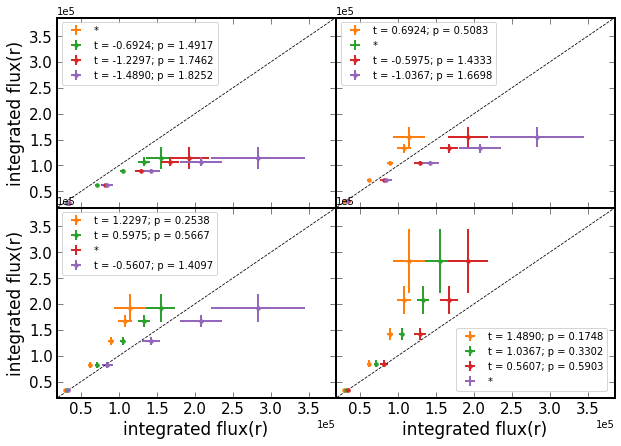

In [135]:
#30 100 500




str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']
colors = ['C1','C2','C3','C4', 'C5']
#nn = [30,50,150,500]

a = min([min(ii) for ii in zz_low])
b = max([max(ii) for ii in zz_up])

wi = 0.5
lws = 0.8
font = 17
fontl = 10

fig = plt.figure(figsize=(10,7))  
for j in range(4):
    ctrl = j
    
    for i in range(4):

        #################################################################################
        if j <= 1:
            ax2 = plt.subplot(2,2,j+1)
        if j > 1:
            ax2 = plt.subplot(2,2,j+1)


        
        hc_ulimit =np.array(zz_up[ctrl])-np.array(zz[ctrl])
        hc_llimit =np.array(zz[ctrl])-np.array(zz_low[ctrl])
        #print(i)
        #print(ctrl)

        if i != ctrl:        
            t, p = tstudent(zz[ctrl], zz[i])
            
            ulimit =np.array(zz_up[i])-np.array(zz[i])
            llimit =np.array(zz[i])-np.array(zz_low[i])
            #plt.plot(zz[i], zz[ctrl],'-',alpha=0.2, lw=1.4, color=colors[i]) 
            plt.errorbar(zz[i], zz[ctrl], xerr=[ulimit,llimit], 
                         yerr=[hc_ulimit,hc_llimit], color=colors[i], 
                         fmt='.',label="t = %.4f"%(t)+'; '+"p = %.4f"%(p), 
                         markersize='7', ecolor=colors[i],capsize=0, elinewidth=2)
        if i == ctrl:   
            plt.plot([1e4, 3e6], [1e4,3e6], 'k--', lw=lws, label='')
            
            plt.errorbar(np.array(zz[i])*0, np.array(zz[ctrl])*0, 
                         xerr=[hc_ulimit,hc_llimit], yerr=[hc_ulimit,hc_llimit], 
                         color=colors[i], fmt='.',label='*', markersize=0, 
                         ecolor=colors[i],capsize=0, elinewidth=2)

        plt.tick_params(direction='in',which='major', length=6, width=wi, labelsize=0.,
                       bottom='on', top='on', left='on', right ='on')
        plt.tick_params(direction='in',which='minor', length=3, width=wi, labelsize=0.,
                       bottom='on', top='on', left='on', right ='on')
        plt.subplots_adjust(wspace=0, hspace=0)
  
        [ax2.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
        plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, fontsize=fontl,borderaxespad=0.,numpoints=1,scatterpoints=1)
        
        if ctrl == 3: 
            plt.legend(bbox_to_anchor=(0.43, 0.37), loc=2, fontsize=fontl,borderaxespad=0.,numpoints=1,scatterpoints=1)

        
        if ctrl == 0 or ctrl == 2: 
            plt.ylabel('integrated flux(r)', fontsize=font)
            plt.yticks(fontsize=15)
        if ctrl == 2 or ctrl == 3: 
            plt.xlabel('integrated flux(r)', fontsize=font)
            plt.xticks(fontsize=15)
        if ctrl == 1 or ctrl == 3:
            plt.yticks(fontsize=0)
        plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        #plt.xlim(1e4, 3e6)
        #plt.ylim(1e4, 3e6)
        plt.ylim(a-10000, b+40000)
        plt.xlim(a-10000, b+40000)


plt.show()